---

### 🎓 **Professor**: Apostolos Filippas

### 📘 **Class**: AI Engineering

### 📋 **Homework 3**: Improving Lexical Search

### 📅 **Due Date**: Day of Lecture 4, 11:59 PM


**Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

You'll apply what we covered in Lecture 3 (Lexical Search & BM25) to a real e-commerce search problem using the **WANDS dataset** 
- WANDS stands for Wayfair Annotated Dataset. It's a dataset of furniture products and search queries, along with human relevance judgments.

You will:
1. **Build a search engine** from scratch using BM25.
2. **Learn how to evaluate search results** using NDCG — a metric for measuring search quality
3. **Attempt to improve your search engine** by adding multiple fields
4. **Use LLMs to improve your search engine** by adding simple query understanding

Yes, *you* will do all these things. Let's go!

---

## Task 1: Environment Setup

First, let's set up your environment and verify everything works.

### 1a. Install dependencies and verify imports

Run `uv add pystemmer` in your terminal to add the Snowball stemmer. Then run the cell below to verify all imports work.

In [3]:
# Task 1a: Verify imports work
import pandas as pd
import numpy as np
from collections import Counter
import string
from pathlib import Path
# a stemmer from `pystemmer` for better tokenization
import Stemmer 
# llm packages
import litellm
from pydantic import BaseModel, Field
from typing import Optional
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Pandas display settings
# pd.set_option('display.max_colwidth', 100)

# Ignore pydantic warnings for litellm
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pydantic")

print("All imports successful!")

All imports successful!


### 1b. Verify API keys

Test that your API keys work by making a simple call.

### 8c. Display the image (5 pts)

In [4]:
# Task 1b: Verify API keys
response = litellm.completion(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": "Say 'API working!' and nothing else."}],
    max_tokens=20
)
print(response.choices[0].message.content)

API working!


---

## Task 2: Load and Explore the WANDS Dataset

The **WANDS dataset** (Wayfair Annotated Dataset) contains:
- 43K furniture products from Wayfair
- 480 real search queries
- 233K human relevance judgments (query-product pairs)

This is a real-world search benchmark used to evaluate e-commerce search systems!

**Data Source**: [WANDS on GitHub](https://github.com/wayfair/WANDS)

The data files are pre-downloaded in the `data/` directory:
- `wayfair-products.csv` - Product catalog
- `wayfair-queries.csv` - Search queries
- `wayfair-labels.csv` - Relevance judgments

### Data Loading Functions (provided)

Run the cell below to define the loading functions.

In [5]:
# Data loading functions (provided)
# Note: Data from WANDS (Wayfair Annotated Dataset)
# Source: https://github.com/wayfair/WANDS

def load_wands_products(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS products from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-products.csv
        
    Returns:
        DataFrame with product information including product_id, product_name,
        product_class, category_hierarchy, product_description, etc.
    """
    filepath = Path(data_dir) / "wayfair-products.csv"
    products = pd.read_csv(filepath, sep='\t')
    products = products.rename(columns={'category hierarchy': 'category_hierarchy'})
    return products

def load_wands_queries(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS queries from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-queries.csv
        
    Returns:
        DataFrame with query_id and query columns
    """
    filepath = Path(data_dir) / "wayfair-queries.csv"
    queries = pd.read_csv(filepath, sep='\t')
    return queries

def load_wands_labels(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS relevance labels from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-labels.csv
        
    Returns:
        DataFrame with query_id, product_id, label (Exact/Partial/Irrelevant),
        and grade (2/1/0) columns
    """
    filepath = Path(data_dir) / "wayfair-labels.csv"
    labels = pd.read_csv(filepath, sep='\t')
    grade_map = {'Exact': 2, 'Partial': 1, 'Irrelevant': 0}
    labels['grade'] = labels['label'].map(grade_map)
    return labels

print("Loading functions defined!")

Loading functions defined!


### 2a. Load the data

Use the provided functions to load all three datasets. Print the number of rows in each.

In [6]:
# Task 2a: Load the data

# YOUR CODE HERE
products_df = load_wands_products(data_dir="data")
queries_df = load_wands_queries(data_dir="data")
labels_df = load_wands_labels(data_dir="data")

print(f"Products rows: {len(products_df)}")
print(f"Queries rows: {len(queries_df)}")
print(f"Labels rows: {len(labels_df)}")

Products rows: 42994
Queries rows: 480
Labels rows: 233448


### 2b. Explore products

List the available columns, and display a few sample products. 

Which columns might be useful for search?

In [7]:
# YOUR CODE HERE
products_df.columns.tolist()

['product_id',
 'product_name',
 'product_class',
 'category_hierarchy',
 'product_description',
 'product_features',
 'rating_count',
 'average_rating',
 'review_count']

In [8]:
# YOUR CODE HERE: First few products in the catalog
products_df.head()

,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count
0,0,solid wood platform bed,Beds,Furniture / Bedroom Furniture / Beds & Headboa...,"good , deep sleep can be quite difficult to ha...",overallwidth-sidetoside:64.7|dsprimaryproducts...,15.0,4.5,15.0
1,1,all-clad 7 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,"create delicious slow-cooked meals , from tend...",capacityquarts:7|producttype : slow cooker|pro...,100.0,2.0,98.0
2,2,all-clad electrics 6.5 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,prepare home-cooked meals on any schedule with...,features : keep warm setting|capacityquarts:6....,208.0,3.0,181.0
3,3,all-clad all professional tools pizza cutter,"Slicers, Peelers And Graters",Browse By Brand / All-Clad,this original stainless tool was designed to c...,overallwidth-sidetoside:3.5|warrantylength : l...,69.0,4.5,42.0
4,4,baldwin prestige alcott passage knob with roun...,Door Knobs,Home Improvement / Doors & Door Hardware / Doo...,the hardware has a rich heritage of delivering...,compatibledoorthickness:1.375 '' |countryofori...,70.0,5.0,42.0


In [9]:
# YOUR CODE HERE: Columns useful for search
useful_columns = ['product_name', 'product_description', 'category_hierarchy', 'brand', 'color', 'material']

print("Columns useful for search:", ", ".join(useful_columns))

Columns useful for search: product_name, product_description, category_hierarchy, brand, color, material


### 2c. Understand relevance judgments

The `labels` dataset contains human judgments of relevance. In particular, for each query-product pair, it contains:
| Label        | Grade | Description                                 |
|--------------|-------|---------------------------------------------|
| Exact        |   2   | This product is exactly what the user wants |
| Partial      |   1   | This product is somewhat relevant           |
| Irrelevant   |   0   | This product doesn't match the query        |

First, let's look at the distribution of grades.

In [10]:
labels_df.head()

,id,query_id,product_id,label,grade
0,0,0,25434,Exact,2
1,1,0,12088,Irrelevant,0
2,2,0,42931,Exact,2
3,3,0,2636,Exact,2
4,4,0,42923,Exact,2


In [11]:
# Task 2c: Understand judgments

# YOUR CODE HERE
counts = labels_df['grade'].value_counts().sort_index()
percentdist = labels_df['grade'].value_counts(normalize=True).sort_index()

In [12]:
# YOUR CODE HERE
distribution = pd.DataFrame({
    'Count': counts,
    'Percentage': percentdist.map(lambda n: f"{n:.2%}")
})

print(distribution)


        Count Percentage
grade                   
0       61201     26.22%
1      146633     62.81%
2       25614     10.97%


---
## Task 3: Build and Run BM25 Search

Now let's build a BM25 search engine! We'll use the same concepts from Lecture 3.

### Provided Functions

We're giving you these functions to work with. Run the next cell to define them, then look at the examples.

| Function | What it does |
|----------|--------------|
| `snowball_tokenize(text)` | Tokenizes text, removes punctuation, stems words |
| `build_index(docs, tokenizer)` | Builds an inverted index from a list of documents |
| `get_tf(term, doc_id, index)` | Gets term frequency for a term in a document |
| `get_df(term, index)` | Gets document frequency for a term (how many docs contain the term) |
| `bm25_idf(df, num_docs)` | Calculates the IDF component of BM25 |
| `bm25_tf(tf, doc_len, avg_doc_len)` | Calculates the TF normalization for BM25 |
| `score_bm25(query, index, ...)` | Scores all documents for a query using BM25 |
| `search_products(query, ...)` | Searches and returns top-k results |

In [13]:
# Provided functions - run this cell to define them

stemmer = Stemmer.Stemmer('english')
punct_trans = str.maketrans({key: ' ' for key in string.punctuation})

def snowball_tokenize(text: str) -> list[str]:
    """
    Tokenize text with Snowball stemming.
    
    Args:
        text: The text to tokenize
        
    Returns:
        List of stemmed tokens
    """
    if pd.isna(text) or text is None:
        return []
    text = str(text).translate(punct_trans)
    tokens = text.lower().split()
    return [stemmer.stemWord(token) for token in tokens]

def build_index(docs: list[str], tokenizer) -> tuple[dict, list[int]]:
    """
    Build an inverted index from a list of documents.
    
    Args:
        docs: List of document strings to index
        tokenizer: Function that takes text and returns list of tokens
        
    Returns:
        index: dict mapping term -> {doc_id: term_count}
        doc_lengths: list of document lengths (in tokens)
    """
    index = {}
    doc_lengths = []
    
    for doc_id, doc in enumerate(docs):
        tokens = tokenizer(doc)
        doc_lengths.append(len(tokens))
        term_counts = Counter(tokens)
        
        for term, count in term_counts.items():
            if term not in index:
                index[term] = {}
            index[term][doc_id] = count
    
    return index, doc_lengths

def get_tf(term: str, doc_id: int, index: dict) -> int:
    """
    Get term frequency for a term in a document.
    
    Args:
        term: The term to look up
        doc_id: The document ID
        index: The inverted index
        
    Returns:
        Term frequency (count), or 0 if not found
    """
    if term in index and doc_id in index[term]:
        return index[term][doc_id]
    return 0

def get_df(term: str, index: dict) -> int:
    """
    Get document frequency for a term.
    
    Args:
        term: The term to look up
        index: The inverted index
        
    Returns:
        Number of documents containing the term
    """
    if term in index:
        return len(index[term])
    return 0

def bm25_idf(df: int, num_docs: int) -> float:
    """
    BM25 IDF formula.
    
    Args:
        df: Document frequency
        num_docs: Total number of documents
        
    Returns:
        IDF score
    """
    return np.log((num_docs - df + 0.5) / (df + 0.5) + 1)

def bm25_tf(tf: int, doc_len: int, avg_doc_len: float, k1: float = 1.2, b: float = 0.75) -> float:
    """
    BM25 TF normalization.
    
    Args:
        tf: Term frequency
        doc_len: Document length in tokens
        avg_doc_len: Average document length
        k1: Saturation parameter (default 1.2)
        b: Length normalization (default 0.75)
        
    Returns:
        Normalized TF score
    """
    return (tf * (k1 + 1)) / (tf + k1 * (1 - b + b * doc_len / avg_doc_len))

def score_bm25(query: str, index: dict, num_docs: int, doc_lengths: list[int], 
               tokenizer, k1: float = 1.2, b: float = 0.75) -> np.ndarray:
    """
    Score all documents using BM25.
    
    Args:
        query: The search query
        index: Inverted index
        num_docs: Total number of documents
        doc_lengths: List of document lengths
        tokenizer: Tokenization function
        
    Returns:
        Array of scores for each document
    """
    query_tokens = tokenizer(query)
    scores = np.zeros(num_docs)
    avg_doc_len = np.mean(doc_lengths) if doc_lengths else 1.0
    
    for token in query_tokens:
        df = get_df(token, index)
        if df == 0:
            continue
        
        idf = bm25_idf(df, num_docs)
        
        if token in index:
            for doc_id, tf in index[token].items():
                tf_norm = bm25_tf(tf, doc_lengths[doc_id], avg_doc_len, k1, b)
                scores[doc_id] += idf * tf_norm
    
    return scores

def search_products(query: str, products_df: pd.DataFrame, index: dict, 
                    doc_lengths: list[int], tokenizer, k: int = 10) -> pd.DataFrame:
    """
    Search products and return top-k results.
    
    Args:
        query: The search query
        products_df: DataFrame of products
        index: Inverted index
        doc_lengths: Document lengths
        tokenizer: Tokenization function
        k: Number of results to return
        
    Returns:
        DataFrame with top-k products and scores
    """
    scores = score_bm25(query, index, len(products_df), doc_lengths, tokenizer)
    top_k_idx = np.argsort(-scores)[:k]
    
    results = products_df.iloc[top_k_idx].copy()
    results['score'] = scores[top_k_idx]
    results['rank'] = range(1, k + 1)
    return results

print("All functions defined!")

All functions defined!


In [14]:
# Examples of each function

# 1. snowball_tokenize - tokenizes and stems text
print("1. snowball_tokenize('Running shoes are amazing!')")
print(f"   -> {snowball_tokenize('Running shoes are amazing!')}")
print("   Notice: 'Running' -> 'run', 'shoes' -> 'shoe', 'amazing' -> 'amaz'")

# 2. build_index - builds inverted index (we'll use a tiny example)
tiny_docs = ["red shoe", "blue shoe", "red hat"]
tiny_index, tiny_lengths = build_index(tiny_docs, snowball_tokenize)
print("\n2. build_index(['red shoe', 'blue shoe', 'red hat'], tokenizer)")
print(f"   Index: {tiny_index}")
print(f"   Lengths: {tiny_lengths}")

# 3. get_tf - get term frequency
print("\n3. get_tf('red', doc_id=0, tiny_index)")
print(f"   -> {get_tf('red', 0, tiny_index)}  (doc 0 = 'red shoe' has 1 'red')")

# 4. get_df - get document frequency  
print("\n4. get_df('red', tiny_index)")
print(f"   -> {get_df('red', tiny_index)}  ('red' appears in 2 documents)")

# 5. bm25_idf - calculate IDF (rare terms get higher scores)
print("\n5. bm25_idf(df=100, num_docs=10000)")
print(f"   -> {bm25_idf(100, 10000):.4f}  (term in 100 of 10000 docs)")

# 6. bm25_tf - normalize term frequency by document length
print("\n6. bm25_tf(tf=3, doc_len=50, avg_doc_len=100)")
print(f"   -> {bm25_tf(3, 50, 100):.4f}  (short doc gets boosted)")

# 7-8. score_bm25 and search_products - we'll use these next!
print("\nWe'll use score_bm25() and search_products() in Task 3a!")

1. snowball_tokenize('Running shoes are amazing!')
   -> ['run', 'shoe', 'are', 'amaz']
   Notice: 'Running' -> 'run', 'shoes' -> 'shoe', 'amazing' -> 'amaz'

2. build_index(['red shoe', 'blue shoe', 'red hat'], tokenizer)
   Index: {'red': {0: 1, 2: 1}, 'shoe': {0: 1, 1: 1}, 'blue': {1: 1}, 'hat': {2: 1}}
   Lengths: [2, 2, 2]

3. get_tf('red', doc_id=0, tiny_index)
   -> 1  (doc 0 = 'red shoe' has 1 'red')

4. get_df('red', tiny_index)
   -> 2  ('red' appears in 2 documents)

5. bm25_idf(df=100, num_docs=10000)
   -> 4.6003  (term in 100 of 10000 docs)

6. bm25_tf(tf=3, doc_len=50, avg_doc_len=100)
   -> 1.7600  (short doc gets boosted)

We'll use score_bm25() and search_products() in Task 3a!


### 3a. Create BM25 index for product_name

Build an inverted index for the `product_name` field and run a sample search for a product.

In [ ]:
# Task 3a: Create BM25 index for product_name

# YOUR CODE HERE
products_docs = products_df['product_name'].astype(str).tolist()
name_index,name_len = build_index(products_docs, snowball_tokenize)

# number of docs and avg len for scorebm25
num_docs = len(products_df) #used in score_bm25()
avg_name_len = sum(name_len) / num_docs


# Sample search: score_bm25() is embedded in search_products()
sample_search = "trestle coffee table"
# Applying score_bm25()
name_bm25 = score_bm25 (query=sample_search, index=name_index, num_docs=num_docs,
                    doc_lengths=name_len, tokenizer=snowball_tokenize, k1=1.2,b=0.75)
# Adding product_name to the search
name_results = search_products(query=sample_search, products_df=products_df, index=name_index, 
                    doc_lengths=name_len, tokenizer=snowball_tokenize, k=10)

In [ ]:
# Top 5 results
name_results.head()

,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count,score,rank
10,10,trestle coffee table,Coffee & Cocktail Tables,Furniture / Living Room Furniture / Coffee Tab...,it is an elegant french design that can be pla...,overallheight-toptobottom:19|overalllength-end...,NaN,NaN,NaN,15.681787,1
36551,36551,trestle coffee table,Coffee & Cocktail Tables,Furniture / Living Room Furniture / Coffee Tab...,a trio of gilded gold and faux ebony cherubs r...,dsprimaryproductstyle : traditional|overalllen...,53.0,5.0,38.0,15.681787,2
13141,13141,newmarch trestle coffee table,Patio Tables|Coffee & Cocktail Tables,Furniture / Living Room Furniture / Coffee Tab...,"this coffee table is ideal for home , living r...",dsprimaryproductstyle : country / farmhouse|ad...,NaN,NaN,NaN,14.514875,3
30600,30600,balli trestle coffee table,NaN,Furniture / Living Room Furniture / Coffee Tab...,rustic hardwood and industrial steel are a mat...,levelofassembly : partial assembly|topshape : ...,NaN,NaN,NaN,14.514875,4
25730,25730,posner trestle coffee table,Coffee & Cocktail Tables,Furniture / Living Room Furniture / Coffee Tab...,"second , only to the sofa , coffee tables are ...",overalllength-endtoend:49.63|dswoodtone : medi...,931.0,4.5,590.0,14.514875,5


### 3b. Add product_description to search

Create a second index for `product_description` and combine scores from both fields.

**Hint**: You can combine the two scores by adding them together. This is like multi-field search from Lecture 3.

In [ ]:
# Task 3b: Add product_description to search

# YOUR CODE HERE
products_desc = products_df['product_description'].astype(str).tolist()
desc_index,desc_len = build_index(products_desc, snowball_tokenize)

# Applying score_bm25()
desc_bm25 = score_bm25 (query=sample_search, index=desc_index, num_docs=num_docs,
                    doc_lengths=desc_len, tokenizer=snowball_tokenize, k1=1.2,b=0.75)
# Adding product_description
desc_results = search_products(query=sample_search, products_df=products_df, index=desc_index, 
                    doc_lengths=desc_len, tokenizer=snowball_tokenize, k=10)
combined_scores = name_bm25 + desc_bm25

In [ ]:
# Top 5 search results with product_description
desc_results.head()

,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count,score,rank
5153,5153,mahurin trestle coffee table,Coffee & Cocktail Tables,Furniture / Living Room Furniture / Coffee Tab...,introduce your home to this wonderful and styl...,levelofassembly : full assembly needed|dssecon...,NaN,NaN,NaN,14.167688,1
37942,37942,charo trestle coffee table,Coffee & Cocktail Tables,Furniture / Living Room Furniture / Coffee Tab...,the charo small/large coffee table is a classi...,countryoforigin : viet nam|overallheight-topto...,4.0,3.5,4.0,13.936017,2
5321,5321,polley dining table,Dining Tables,Furniture / Kitchen & Dining Furniture / Dinin...,this polley dining table will be an ideal sett...,style : farmhouse / country|overalllength-endt...,4.0,3.5,4.0,12.988621,3
16553,16553,billingsley solid wood cross legs coffee table,Coffee & Cocktail Tables,Furniture / Living Room Furniture / Coffee Tab...,anchor any seating ensemble in curated industr...,basematerialdetails : acacia wood|countryofori...,294.0,4.5,216.0,12.884700,4
23721,23721,kirchner trestle coffee table,Coffee & Cocktail Tables,Furniture / Living Room Furniture / Coffee Tab...,this coffee table completes your living room '...,basetype : trestle|levelofassembly : full asse...,709.0,5.0,445.0,12.842562,5


In [19]:
combined_scores

array([0.        , 1.41224232, 0.        , ..., 7.98969815, 0.        ,
       3.90153643], shape=(42994,))

---

## Task 4: Measuring Search Quality

We built a little search engine. How do we know if it's any good?

Consider two search results for "coffee table":

| Ranking A | Ranking B |
|-----------|-----------|
| 1. Wooden Coffee Table (Exact) | 1. Metal Lamp (Irrelevant) |
| 2. Glass Coffee Table (Exact) | 2. Wooden Coffee Table (Exact) |
| 3. Metal Lamp (Irrelevant) | 3. Glass Coffee Table (Exact) |

### A. Precision

One way to measure the quality of a ranking is to look at the precision within these first 3 results. 
- Precision is the ratio of relevant results to total results at position k.
- We call this precision@3, and more generally precision@k is the ratio of relevant results to total results at position k.
  
In this scenario, if we consider "exact" results as relevant, then both rankings have precision@3 = 2/3.

### B. DCG

Both rankings have the same precision, but Ranking A is clearly better 
- users look at results from the top down, and most people never scroll past the first few results
- as such, rankings that return relevant results earlier are better

So we need a metric that rewards **relevant** results, and rewards them **more** when they appear at the **top**

NDCG (Normalized Discounted Cumulative Gain) does this by giving each result a "gain" based on its relevance, then **discounting** that gain based on position.

**The formula** for each result at position $i$:

$$\text{gain}_i = \frac{2^{\text{relevance}} - 1}{\log_2(i + 1)}$$

- **Numerator** $(2^{\text{relevance}} - 1)$: How relevant is this result?
  - Irrelevant (0): $2^0 - 1 = 0$ (no gain)
  - Partial (1): $2^1 - 1 = 1$ (some gain)
  - Exact (2): $2^2 - 1 = 3$ (lots of gain!)
  
- **Denominator** $\log_2(i + 1)$: The "discount" based on position
  - Position 1: $\log_2(2) = 1$ (no discount)
  - Position 2: $\log_2(3) = 1.58$ (small discount)
  - Position 10: $\log_2(11) = 3.46$ (bigger discount)

**DCG** sums the discounted score for each result

$$\text{DCG} = \sum_{i=1}^{k} \frac{2^{\text{relevance}_i} - 1}{\log_2(i + 1)}$$

### 3. NDCG: Normalized DCG

One problem with DCG is that the score depends on how many relevant products exist. 
- A query with 10 exact matches will have a higher DCG than one with only 2, even if both rankings are "perfect."

One solution is to normalize by the *ideal* DCG — what the score would be if we ranked everything perfectly (all relevant results at the top).

$$\text{NDCG} = \frac{\text{DCG}}{\text{Ideal DCG}}$$

- **NDCG = 1.0**: Perfect -- best possible order
- **NDCG = 0.5**: OK -- some good some bad
- **NDCG = 0.0**: Worst -- results are irrelevant

**Read the above carefully.** In the next cell, explain in your own words: why does the discount formula use $\log_2$? What happens to results at position 1 vs position 10?

In [ ]:
# Task 4a: Answer in a comment
# Why does DCG use log2 for the discount? What's the effect on position 1 vs position 10?
#
# YOUR ANSWER HERE
# DCG uses log2 for the discount to model the decline in user attention as they scan results from top to bottom.
# The approach gives a lower discount to position 1 where user attention is highest vs a bigger discount at position 10.
# As a resutl, relevant items at position 1 contribute more to the DCG than item at position 10, strongly rewarding top-ranked results.


# Cite source:
# Mondal, S. (2024, October 15). *Normalized discounted cumulative gain (NDCG) — The ultimate ranking metric*. 
# Towards Data Science. [https://towardsdatascience.com/normalized-discounted-cumulative-gain-ndcg-the-ultimate-ranking-metric-437b03529f75/](https://towardsdatascience.com/normalized-discounted-cumulative-gain-ndcg-the-ultimate-ranking-metric-437b03529f75/)

### 4b. Calculate NDCG by hand

Let's work through an example step by step.

**Scenario**: You search for "wooden coffee table" and get these results:

| Position | Product | Relevance |
|----------|---------|----------|
| 1 | Glass Coffee Table | Partial (1) |
| 2 | Wooden Coffee Table | Exact (2) |
| 3 | Wooden Side Table | Partial (1) |
| 4 | Metal Coffee Table | Irrelevant (0) |
| 5 | Wooden Coffee Table (different) | Exact (2) |

**Your task**: Calculate DCG and NDCG@5 by hand.

In [ ]:
# Task 4b: Calculate NDCG by hand

4b. Calculating NDCG by hand


| Position (i)| Relevance| Gain $(2^{\text{relevance}} - 1)$ | Discount ${\log_2(i + 1)}$| Discounted Gain ${(Gain/Discount)}$ |
|----------|---------|----------|---------|----------|
| 1 | Partial (1) | $(2^{\text{1}} - 1) = 1$ |${\log_2(1 + 1)} = 1$|1|
| 2 | Exact (2) | $(2^{\text{2}} - 1) = 3$ |${\log_2(2 + 1)} = 1.5850$|1.892744|
| 3 | Partial (1) | $(2^{\text{1}} - 1) = 1$ |${\log_2(3 + 1)} = 2$|0.5|
| 4 | Irrelevant (0) | $(2^{\text{0}} - 1) = 0$ |${\log_2(4 + 1)} = 2.3219$|0|
| 5 | Exact (2) | $(2^{\text{2}} - 1) = 3$ |${\log_2(5 + 1)} = 2.5850$|1.160542|

**DCG = 1 +1.892744 + 0.5 + 0 + 1.160542 = 4.553282 ≈ 4.5533**

Ideal DCG: What the score would be if we ranked everything perfectly (all relevant results at the top)

| Position (i)| Relevance| Gain $(2^{\text{relevance}} - 1)$ | Discount ${\log_2(i + 1)}$| Discounted Gain ${(Gain/Discount)}$ |
|----------|---------|----------|---------|----------|
| 1 | Exact (2) | $(2^{\text{2}} - 1) = 3$ |${\log_2(1 + 1)} = 1$|3|
| 2 | Exact (2) | $(2^{\text{2}} - 1) = 3$ |${\log_2(2 + 1)} = 1.5850$|1.8927|
| 3 | Partial (1) | $(2^{\text{1}} - 1) = 1$ |${\log_2(3 + 1)} = 2$|0.5|
| 4 | Partial (1) | $(2^{\text{1}} - 1) = 1$ |${\log_2(4 + 1)} = 2.3219$|0.4307|
| 5 | Irrelevant (0) | $(2^{\text{2}} - 1) = 0$ |${\log_2(5 + 1)} = 2.5850$|0|

**Ideal DCG = 1 +1.8927 + 0.5 + 0.4307 + 0 = 5.8234**

**NDCG**
$$\text{NDCG} = \frac{\text{4.5533}}{\text{5.8234}} = 0.781897 ≈ 0.7819$$

### 4c. Implement NDCG function

Now implement the NDCG calculation in code. Verify your implementation matches your hand calculation!

In [ ]:
# Task 4c: Implement NDCG function

# YOUR CODE HERE
def calculate_dcg(relevances: list[int], k: int = 5):

    rel = np.asarray(relevances)[:k]
    if rel.size == 0:
        return 0.0
    
    # Numerator: 2^relevance - 1
    gains = 2**rel - 1

    # Denominator: Discount log2(i + 1), using i+2 because np.arange starts at 0
    discount = np.log2(np.arange(len(rel)) + 2)
    dcg = np.sum(gains/discount)

    return dcg

def calculate_ndcg(relevances: list[int], k: int = 5):

    # Calculate DCG
    actual_dcg = calculate_dcg(relevances,k)

    # Calculate Ideal DCG
    ideal_rel = sorted(relevances, reverse=True) #sorts relevance in decreasing order
    idcg = calculate_dcg(ideal_rel,k)

    # Calculate NDCG (dcg/ideal dcg)
    ndcg = 0.0 if idcg==0 else (actual_dcg / idcg)

    return ndcg

In [21]:
# Verify your implementation matches your hand calculation
test_relevances = [1, 2, 1, 0, 2]

dcg = calculate_dcg(test_relevances, k=5)
ndcg = calculate_ndcg(test_relevances, k=5)

print(f"DCG@5 = {dcg:.4f}")
print(f"NDCG@5 = {ndcg:.4f}")

# These should match your hand calculations from Task 4b!

DCG@5 = 4.5533
NDCG@5 = 0.7819


---

## Task 5: Evaluate Your Search Strategy

Now let's evaluate our BM25 search across all queries in the WANDS dataset.

### Evaluation Helper Functions (provided)

In [22]:
# Evaluation helper functions (provided)

def get_relevance_grades(product_ids: list[int], query_id: int, labels_df: pd.DataFrame) -> list[int]:
    """
    Get relevance grades for a list of product IDs given a query.
    
    Args:
        product_ids: List of product IDs in rank order
        query_id: The query ID
        labels_df: DataFrame with relevance labels
        
    Returns:
        List of relevance grades (0, 1, or 2) for each product
    """
    # Get labels for this query
    query_labels = labels_df[labels_df['query_id'] == query_id]
    label_dict = dict(zip(query_labels['product_id'], query_labels['grade']))
    
    # Look up grades for each product (default to 0 if not labeled)
    return [label_dict.get(pid, 0) for pid in product_ids]

def evaluate_single_query(query_text: str, query_id: int, products_df: pd.DataFrame,
                          labels_df: pd.DataFrame, search_func, k: int = 10) -> float:
    """
    Evaluate search for a single query.
    
    Args:
        query_text: The search query text
        query_id: The query ID for looking up labels
        products_df: DataFrame of products
        labels_df: DataFrame with relevance labels
        search_func: Function that takes query and returns DataFrame with product_id column
        k: Number of results to consider
        
    Returns:
        NDCG@k score for this query
    """
    results = search_func(query_text)
    product_ids = results['product_id'].tolist()[:k]
    relevances = get_relevance_grades(product_ids, query_id, labels_df)
    return calculate_ndcg(relevances, k)

def evaluate_search(search_func, products_df: pd.DataFrame, queries_df: pd.DataFrame,
                    labels_df: pd.DataFrame, k: int = 10, verbose: bool = True) -> pd.DataFrame:
    """
    Evaluate search across all queries.
    
    Args:
        search_func: Function that takes query string and returns DataFrame with product_id
        products_df: DataFrame of products
        queries_df: DataFrame of queries
        labels_df: DataFrame with relevance labels
        k: Number of results to consider
        verbose: Whether to print progress
        
    Returns:
        DataFrame with query_id, query, and ndcg columns
    """
    results = []
    
    for _, row in queries_df.iterrows():
        query_id = row['query_id']
        query_text = row['query']
        
        ndcg = evaluate_single_query(query_text, query_id, products_df, 
                                     labels_df, search_func, k)
        results.append({
            'query_id': query_id,
            'query': query_text,
            'ndcg': ndcg
        })
    
    results_df = pd.DataFrame(results)
    
    if verbose:
        print(f"Evaluated {len(results_df)} queries")
        print(f"Mean NDCG@{k}: {results_df['ndcg'].mean():.4f}")
    
    return results_df

print("Evaluation functions defined!")

Evaluation functions defined!


### 5a. Run evaluation on all queries

Create a search function and evaluate it on all queries.

In [ ]:
# Task 5a: Run evaluation on all queries

# YOUR CODE HERE
def combined_search(query_text: str):
    
    # Get name scores
    name_scores = score_bm25(query_text, name_index, num_docs, name_len, snowball_tokenize)

    # Get description scores
    desc_scores = score_bm25(query_text, desc_index, num_docs, desc_len, snowball_tokenize)
    
    # Sum scores
    total_scores = name_scores + desc_scores
    
    # 4. Rank them (using the logic from search_products function)
    top_indices = np.argsort(-total_scores)
    results = products_df.iloc[top_indices].copy()
    results['score'] = total_scores[top_indices]
    
    return results

In [24]:
# Evaluate NDCG@10 across all queries
eval_results = evaluate_search(
    search_func=combined_search,
    products_df=products_df,
    queries_df=queries_df,
    labels_df=labels_df,
    k=10
)

# Show the top performing queries
print("\nTop 5 Queries by NDCG:")
print(eval_results.nlargest(5, 'ndcg')[['query', 'ndcg']])

Evaluated 480 queries
Mean NDCG@10: 0.8682

Top 5 Queries by NDCG:
                       query  ndcg
1         smart coffee table   1.0
2                   dinosaur   1.0
4  chair and a half recliner   1.0
5          sofa with ottoman   1.0
8       home sweet home sign   1.0


### 5b. Identify failing queries

Find queries where our search performed poorly (NDCG = 0 or very low). Analyze one of them.

In [25]:
# Task 5b: Identify failing queries

# YOUR CODE HERE
# Sort by NDCG to find the 0s and low scorers
poor_queries = eval_results.sort_values('ndcg').head(10)

print("Queries with the lowest NDCG:")
print(poor_queries[['query_id', 'query', 'ndcg']])

Queries with the lowest NDCG:
     query_id                                query  ndcg
458       465                       white abstract   0.0
446       453                   midcentury tv unit   0.0
377       383                         minnestrista   0.0
147       147                         drum picture   0.0
394       400  small ladies rocker swivel recliner   0.0
403       409                           teal chair   0.0
240       244            pull out sleeper loveseat   0.0
299       304                             merlyn 6   0.0
343       348                        one alium way   0.0
204       207       dull bed with shirt head board   0.0


In [ ]:
# Analyzing specific query: query_id = 147 (drum picture)

query_check = 147 #Using query_id = 147 i.e. drum picture for analysis

# What search returned
query_text = queries_df[queries_df['query_id'] == query_check]['query'].values[0]
my_results = combined_search(query_text).head(10)

# What was labelled relevant
ideal_results = labels_df[labels_df['query_id'] == query_check].sort_values('grade', ascending=False)
ideal_product_ids = ideal_results['product_id'].head(10).tolist()
ideal_products = products_df[products_df['product_id'].isin(ideal_product_ids)]

print(f"Analysis for Query: '{query_text}'")
print("\nTop results returned by BM25:")
print(my_results[['product_id','product_name', 'score']])
print("\nActual relevant products missed:")
print(ideal_products[['product_id','product_name']])

Analysis for Query: 'drum picture'

Top results returned by BM25:
       product_id                                   product_name      score
15321       15321                 lavada 4-light drum chandelier  14.677446
13904       13904                 jurgens mahogany picture frame  13.923356
29189       29189                         satrogan picture frame  13.800654
27494       27494                    gemmill matte picture frame  13.604143
39625       39625                           design picture frame  13.407070
34840       34840                 elysium elephant picture frame  13.348013
24581       24581  denise 5 - light candle style drum chandelier  13.325407
29202       29202                  choe watercolor picture frame  13.226719
2428         2428       ncaa university of alabama picture frame  13.035251
16215       16215                           single picture frame  13.023064

Actual relevant products missed:
       product_id                                       product_

### 5c. Analyze the distribution

Visualize the distribution of NDCG scores.

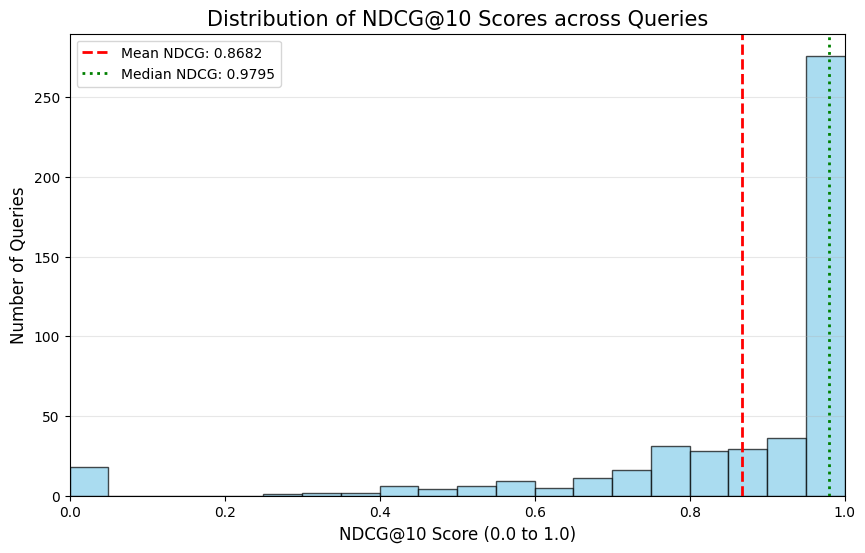

In [27]:
# Task 5c: Analyze the distribution

# YOUR CODE HERE:
# Collaboration with Gemini
import matplotlib.pyplot as plt

# Create  plot
plt.figure(figsize=(10, 6))
plt.hist(eval_results['ndcg'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# Adds vertical line for the mean
mean_ndcg = eval_results['ndcg'].mean()
plt.axvline(mean_ndcg, color='red', linestyle='dashed', linewidth=2, 
            label=f'Mean NDCG: {mean_ndcg:.4f}')

# Adds vertical line for the median
median_ndcg = eval_results['ndcg'].median()
plt.axvline(median_ndcg, color='green', linestyle='dotted', linewidth=2, 
            label=f'Median NDCG: {median_ndcg:.4f}')

# Formatting
plt.title('Distribution of NDCG@10 Scores across Queries', fontsize=15)
plt.xlabel('NDCG@10 Score (0.0 to 1.0)', fontsize=12)
plt.ylabel('Number of Queries', fontsize=12)
plt.xlim(0, 1.0) # NDCG is always between 0 and 1
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Display the plot
plt.savefig('ndcg_distribution.png')

---

## Task 6: Improve Search with Additional Fields

Our baseline only searches the `product_name` field. Let's improve by adding more fields!

### 6a. Index product_class field

The `product_class` field contains the category of the product (e.g., "Rugs", "Coffee Tables"). This is a powerful signal!

Create a search function that combines all three fields (name, description, class).

In [28]:
# Task 6a: Index product_class field

# YOUR CODE HERE
products_class = products_df['product_class'].astype(str).tolist()
class_index,class_len = build_index(products_class, snowball_tokenize)

In [ ]:
# Three field search
def three_field_search(query_text:str):
    
    # Get scores for product_name, description, class
    name_scores = score_bm25(query_text, name_index, num_docs, name_len, snowball_tokenize)
    desc_scores = score_bm25(query_text, desc_index, num_docs, desc_len, snowball_tokenize)
    class_scores = score_bm25(query_text, class_index, num_docs, class_len, snowball_tokenize)
    
    # Sum scores
    total_scores = name_scores + desc_scores + class_scores
    
    # Rank them (using the logic from search_products function)
    top_indices = np.argsort(-total_scores)
    results = products_df.iloc[top_indices].copy()
    results['score'] = total_scores[top_indices]
    
    return results

In [30]:
# Test three-field search
three_field_search("ottoman").head(10)

,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count,score
17938,17938,alexzander cocktail ottoman,Ottomans,Furniture / Living Room Furniture / Ottomans &...,this ottoman creates a casual inviting atmosph...,"productcare : spot clean using the foam only ,...",50.0,4.5,40.0,18.755001
4792,4792,kirkby tufted ottoman,Ottomans,Furniture / Living Room Furniture / Ottomans &...,upholstered in linen blend fabric . wood is fi...,upholsterycolor : gray|overalldepth-fronttobac...,33.0,5.0,29.0,18.536611
25650,25650,dengler tufted ottoman,Ottomans,Furniture / Living Room Furniture / Ottomans &...,wonderful ottoman . rectangle-shaped and long ...,pattern : striped|upholsterymaterialdetails:66...,29.0,4.5,18.0,18.513202
4591,4591,upholstered tufted storage ottoman,Ottomans,Furniture / Living Room Furniture / Ottomans &...,this storage ottoman features a contemporary s...,weightcapacity:220|style : modern & contempora...,1.0,5.0,1.0,18.492416
20677,20677,sazur 40 '' square standard ottoman,Ottomans,Furniture / Living Room Furniture / Ottomans &...,the living room ottoman will upgrade your livi...,weightcapacity:250|seatfillmaterial : foam|est...,NaN,NaN,NaN,18.442280
28647,28647,camas tufted storage ottoman,Ottomans,Furniture / Living Room Furniture / Ottomans &...,a traditional design gets a stylish update in ...,legcolor : black|overallheight-toptobottom:16....,426.0,5.0,291.0,18.435999
19646,19646,brünhild 32 '' rectangle standard ottoman,Ottomans,Furniture / Living Room Furniture / Ottomans &...,mid-century modern ottoman features wooden base,weightcapacity:300|warrantylength:3 years|fram...,NaN,NaN,NaN,18.308548
22541,22541,iconium 16.3 '' wide round storage ottoman,Ottomans,Furniture / Living Room Furniture / Ottomans &...,bring both storage and seating to your living ...,minimumdoorwidth-sidetoside:16.3|dsprimaryprod...,210.0,4.5,138.0,18.180919
28509,28509,arjunan 27 '' square standard ottoman,Ottomans,Furniture / Living Room Furniture / Ottomans &...,the ultimate in function and style is here wit...,dsprimaryproductstyle : modern|dssecondaryprod...,85.0,4.0,71.0,18.164296
28511,28511,arjunreddy sleeper bed tufted ottoman,Ottomans,Furniture / Living Room Furniture / Ottomans &...,"this ottoman is an attractive ottoman , perfec...",upholsterymaterial : microfiber/microsuede|uph...,34.0,4.5,27.0,18.142287


### 6b. Evaluate three-field search

Now evaluate your three-field search on all queries to see how it compares to the baseline.

In [66]:
# Task 6b: Evaluate three-field search

# YOUR CODE HERE
# Evaluate NDCG@10 across all queries using 3-field search
three_field_results = evaluate_search(
    search_func=three_field_search,
    products_df=products_df,
    queries_df=queries_df,
    labels_df=labels_df,
    k=10
)

# Show the top performing queries
print("\nTop 5 Queries by NDCG using 3-field search:")
print(three_field_results.nlargest(5, 'ndcg')[['query', 'ndcg']])

Evaluated 480 queries
Mean NDCG@10: 0.8791

Top 5 Queries by NDCG using 3-field search:
                    query  ndcg
0             salon chair   1.0
1      smart coffee table   1.0
2                dinosaur   1.0
9   coffee table fire pit   1.0
11              ombre rug   1.0


### 6c. Compare to baseline

Analyze which queries improved and which degraded when using three-field search.

In [36]:
# Collaboration with Gemini
# Merge the two result sets on query_id
comparison_df = eval_results[['query_id', 'query', 'ndcg']].merge(
    three_field_results[['query_id', 'ndcg']], 
    on='query_id', 
    suffixes=('_baseline', '_3field')
)

# Calculate the improvement/degradation
comparison_df['delta'] = comparison_df['ndcg_3field'] - comparison_df['ndcg_baseline']

# Separate the winners from the losers
improved = comparison_df[comparison_df['delta'] > 0.01].sort_values('delta', ascending=False)
degraded = comparison_df[comparison_df['delta'] < -0.01].sort_values('delta')
neutral = comparison_df[abs(comparison_df['delta']) <= 0.01]

print(f"Improved: {len(improved)} queries")
print(f"Degraded: {len(degraded)} queries")
print(f"Unchanged: {len(neutral)} queries")

Improved: 112 queries
Degraded: 70 queries
Unchanged: 298 queries


In [37]:
#Top 5 results
print(f"Top 5 Improved Queries:")
improved.head(5)

Top 5 Improved Queries:


,query_id,query,ndcg_baseline,ndcg_3field,delta
339,344,ottoman bed queen,0.000000,0.693426,0.693426
447,454,carpet 5x6,0.386853,0.955024,0.568171
240,244,pull out sleeper loveseat,0.000000,0.505128,0.505128
403,409,teal chair,0.000000,0.471628,0.471628
84,84,full metal bed rose gold,0.554827,0.996349,0.441522


In [38]:
print(f"Top 5 Degraded Queries:")
degraded.head(5)

Top 5 Degraded Queries:


,query_id,query,ndcg_baseline,ndcg_3field,delta
304,309,moen 5995 arbor one,0.921787,0.289065,-0.632722
45,45,70s inspired furniture,0.583342,0.000000,-0.583342
42,42,toddler couch fold out,0.919721,0.468451,-0.451270
13,13,outdoor privacy wall,0.927414,0.500000,-0.427414
134,134,black hanging bookshelf,1.000000,0.630930,-0.369070


In [39]:
print(f"Top 5 Unchanged Queries:")
neutral.head(5)

Top 5 Unchanged Queries:


,query_id,query,ndcg_baseline,ndcg_3field,delta
0,0,salon chair,0.995955,1.000000,0.004045
1,1,smart coffee table,1.000000,1.000000,0.000000
2,2,dinosaur,1.000000,1.000000,0.000000
3,3,turquoise pillows,0.890705,0.897263,0.006558
7,7,driftwood mirror,0.996976,0.990570,-0.006406


---

## Task 7: Query Understanding with LLM

Sometimes users search for "star wars rug" when they really want a "rug with Star Wars theme". An LLM can help us understand what the user is actually looking for!

### 7a. Extract product type from query

Write a function using LiteLLM with structured outputs (Pydantic) to extract key information from a query.

In [63]:
# Task 7a: Extract product type, theme, material, color, and any other information you deem relevcant from the query

# YOUR CODE HERE
from pydantic import BaseModel, Field
from typing import List, Optional, Dict
from litellm import completion

class ProductQuery(BaseModel):
    product_type: str = Field(
        description="Item being searched"
    )
    theme: Optional[str] = Field(
        description="The style or theme"
    )
    material: Optional[str] = Field(
        description="What the product is made of"
    )
    color: Optional[str] = Field(
        description="Color of item"
        )
    other_attributes: Optional[str] = Field(
        description="Any other relevant details e.g. size or shape"
    )

def extract_query(query_text: str) -> ProductQuery:
    """
    Turns querty into ProductQuery object using gpt-4o-mini.
    """
    response = completion(
        model="gpt-4o-mini", # Switched to gpt-4o-mini
        messages=[
            {
                "role": "system", 
                "content": "You are an expert e-commerce search parser. Extract structured details from the user's search query into JSON."
            },
            {"role": "user", "content": query_text}
        ],
        response_format=ProductQuery
    )

    # JSON response into the Pydantic model
    json_string = response.choices[0].message.content
    return ProductQuery.model_validate_json(json_string)

In [64]:
# Test your query understanding function by running it against these test queries
test_queries = [
    "star wars rug",
    "wooden coffee table",
    "blue leather sofa",
    "modern metal bookshelf"
]

for q in test_queries:
    result = extract_query(q)
    print(f"Query: {q}")
    print(f"Product Type: {result.product_type}")
    print(f"Theme: {result.theme}")
    print(f"Material: {result.material}")
    print(f"Color: {result.color}")
    print(f"Other: {result.other_attributes}")
    print("=" * 30)

Query: star wars rug
Product Type: rug
Theme: Star Wars
Material: None
Color: None
Other: None
Query: wooden coffee table
Product Type: coffee table
Theme: None
Material: wood
Color: None
Other: None
Query: blue leather sofa
Product Type: sofa
Theme: None
Material: leather
Color: blue
Other: None
Query: modern metal bookshelf
Product Type: bookshelf
Theme: modern
Material: metal
Color: None
Other: None


### 7b. Create an LLM-enhanced search

Use the extracted product type to boost matching results. If the LLM identifies "rug" as the product type, boost products where `product_class` contains "rug".

In [65]:
# Task 7b: Create an LLM-enhanced search

# YOUR CODE HERE

def boosted_search(query_text:str, k:int = 10, boost_wgt:float = 2.0):
    
    # Extract key info from query: product_type, colore, theme etc.
    query_info = extract_query(query_text)

    # Get BM25 scores for product_name, description, class
    name_scores = score_bm25(query_text, name_index, num_docs, name_len, snowball_tokenize)
    desc_scores = score_bm25(query_text, desc_index, num_docs, desc_len, snowball_tokenize)
    class_scores = score_bm25(query_text, class_index, num_docs, class_len, snowball_tokenize)
    
    # Sum scores
    total_scores = name_scores + desc_scores + class_scores
    
    # Collaboration with Gemini
    # Applying the Boost
    # If the LLM identifies a 'product_type', we give a multiplier to items in that category
    if query_info.product_type:
        # Score the specific type against the category/class index
        type_match_scores = score_bm25(query_info.product_type, class_index, num_docs, class_len, snowball_tokenize)
        
        # Create a binary mask (1.0 for match, 0.0 for no match)
        boost_mask = (type_match_scores > 0).astype(float)
        
        # Apply multiplicative boost: 
        # Final Score = Original Score * (1.0 + boost_mask * (boost_wgt - 1.0))
        # If boost_wgt is 2.0, matches are multiplied by 2.0, others by 1.0
        total_scores = total_scores * (1.0 + boost_mask * (boost_wgt - 1.0))

    # Rank them and return top K(using the logic from search_products function)
    top_indices = np.argsort(-total_scores)
    results = products_df.iloc[top_indices].copy()
    results['score'] = total_scores[top_indices]
    
    return results

In [ ]:
# YOUR CODE HERE
sample_query = "bohemian machine-washable rug"

boosted_results = boosted_search(sample_query,k=10)
print("\nTop 10 Results using LLM-enhanced search:")
boosted_results.head(10)


Top 10 Results using LLM-enhanced search:


,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count,score
10867,10867,bohemian distressed geometric cream area rug,Area Rugs,Rugs / Area Rugs,"experience the comfort , durability and style ...",overalllength-endtoend:60|pattern : no pattern...,14.0,5.0,9.0,53.732896
10861,10861,bohemian geometric shag dark gray/cream area rug,Area Rugs,Rugs / Area Rugs,surround your home with these cloud-like shag ...,rugsize:5 ' x 7'|pattern : geometric|primaryco...,101.0,4.5,73.0,48.803857
2134,2134,ametra plum rug,Area Rugs,Rugs / Area Rugs,"this rug is antibacterial , non-stick , non-sl...",backingmaterialdetails : polypropylene|rugsize...,NaN,NaN,NaN,45.884729
2135,2135,ametria plum rug,Area Rugs,Rugs / Area Rugs,"this rug is antibacterial , non-stick , non-sl...",backingmaterialdetails : polypropylene|primary...,NaN,NaN,NaN,45.884729
20109,20109,massimo bohemian medallion textured weave indo...,Area Rugs,Rugs / Area Rugs,this colorful medallion rug adds rich bohemian...,dsprimaryproductstyle : boho|productcare : vac...,NaN,NaN,NaN,45.541823
20110,20110,truman bohemian medallion textured weave indoo...,Area Rugs,Rugs / Area Rugs,"with its star-inspired medallion , this border...",technique : power loom|holidayoccasion : no ho...,221.0,5.0,158.0,45.265475
20111,20111,truman bohemian medallion textured weave indoo...,Area Rugs,Rugs / Area Rugs,"with its star-inspired medallion , this border...",productcare : vacuum with no beater bar/rotati...,178.0,4.5,122.0,45.265475
2136,2136,round floral shag pink/blue area rug,Area Rugs,Rugs / Area Rugs,"this rug is antibacterial , non-stick , non-sl...",dssecondaryproductstyle : classic boho|country...,NaN,NaN,NaN,43.754074
10882,10882,dominik multicolor rug,Area Rugs,Rugs / Area Rugs,"experience the comfort , durability , and styl...",overalllength-endtoend:84|construction : machi...,1128.0,4.5,664.0,43.333223
41868,41868,gunter bohemian geometric khaki/teal indoor/ou...,Area Rugs,Rugs / Area Rugs,this is a beautifully made rug that is outdoor...,rugshape : rectangle|materialdetails:100 % pol...,315.0,5.0,217.0,43.194272


In [94]:
#Comparison to baseline and three-field search
baseline = combined_search(sample_query)
three_field = three_field_search(sample_query)

print("f\nTop 5 Results using Baseline search:")
display(baseline.head())
print("\nTop 5 Results using 3-Field search:")
display(three_field.head())
print("\nTop 5 Results using LLM-enhanced search:")
display(boosted_results.head())

f
Top 5 Results using Baseline search:


,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count,score
10867,10867,bohemian distressed geometric cream area rug,Area Rugs,Rugs / Area Rugs,"experience the comfort , durability and style ...",overalllength-endtoend:60|pattern : no pattern...,14.0,5.0,9.0,23.324731
10859,10859,bohemian gray/beige stair tread,Stair Treads,Rugs / Stair Tread Rugs,"enrich your stairs with these stunning , yet p...",location : indoor use only|productcare : machi...,56.0,4.0,40.0,21.721340
10861,10861,bohemian geometric shag dark gray/cream area rug,Area Rugs,Rugs / Area Rugs,surround your home with these cloud-like shag ...,rugsize:5 ' x 7'|pattern : geometric|primaryco...,101.0,4.5,73.0,20.860212
2134,2134,ametra plum rug,Area Rugs,Rugs / Area Rugs,"this rug is antibacterial , non-stick , non-sl...",backingmaterialdetails : polypropylene|rugsize...,NaN,NaN,NaN,19.400647
2135,2135,ametria plum rug,Area Rugs,Rugs / Area Rugs,"this rug is antibacterial , non-stick , non-sl...",backingmaterialdetails : polypropylene|primary...,NaN,NaN,NaN,19.400647



Top 5 Results using 3-Field search:


,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count,score
10867,10867,bohemian distressed geometric cream area rug,Area Rugs,Rugs / Area Rugs,"experience the comfort , durability and style ...",overalllength-endtoend:60|pattern : no pattern...,14.0,5.0,9.0,26.866448
10861,10861,bohemian geometric shag dark gray/cream area rug,Area Rugs,Rugs / Area Rugs,surround your home with these cloud-like shag ...,rugsize:5 ' x 7'|pattern : geometric|primaryco...,101.0,4.5,73.0,24.401929
2134,2134,ametra plum rug,Area Rugs,Rugs / Area Rugs,"this rug is antibacterial , non-stick , non-sl...",backingmaterialdetails : polypropylene|rugsize...,NaN,NaN,NaN,22.942364
2135,2135,ametria plum rug,Area Rugs,Rugs / Area Rugs,"this rug is antibacterial , non-stick , non-sl...",backingmaterialdetails : polypropylene|primary...,NaN,NaN,NaN,22.942364
20109,20109,massimo bohemian medallion textured weave indo...,Area Rugs,Rugs / Area Rugs,this colorful medallion rug adds rich bohemian...,dsprimaryproductstyle : boho|productcare : vac...,NaN,NaN,NaN,22.770912



Top 5 Results using LLM-enhanced search:


,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count,score
10867,10867,bohemian distressed geometric cream area rug,Area Rugs,Rugs / Area Rugs,"experience the comfort , durability and style ...",overalllength-endtoend:60|pattern : no pattern...,14.0,5.0,9.0,53.732896
10861,10861,bohemian geometric shag dark gray/cream area rug,Area Rugs,Rugs / Area Rugs,surround your home with these cloud-like shag ...,rugsize:5 ' x 7'|pattern : geometric|primaryco...,101.0,4.5,73.0,48.803857
2134,2134,ametra plum rug,Area Rugs,Rugs / Area Rugs,"this rug is antibacterial , non-stick , non-sl...",backingmaterialdetails : polypropylene|rugsize...,NaN,NaN,NaN,45.884729
2135,2135,ametria plum rug,Area Rugs,Rugs / Area Rugs,"this rug is antibacterial , non-stick , non-sl...",backingmaterialdetails : polypropylene|primary...,NaN,NaN,NaN,45.884729
20109,20109,massimo bohemian medallion textured weave indo...,Area Rugs,Rugs / Area Rugs,this colorful medallion rug adds rich bohemian...,dsprimaryproductstyle : boho|productcare : vac...,NaN,NaN,NaN,45.541823


---
## Task 8: Submit via Pull Request

Now let's submit your work using the Git workflow from previous homeworks.
- [ ] Create a new branch called `homework-3`
- [ ] Commit you work and push it to the branch
- [ ] Create a PR with a nice description of your changes
- [ ] Merge the PR to your main branch
  
**The TA will verify your submission by checking the merged PR on your GitHub repo.**

**Also remember to submit your homework on Blackboard!**
